<a href="https://colab.research.google.com/github/nauman-akram/MSDS19041_COVID19_DLSpring2020/blob/master/covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

In [2]:
drive.mount("./gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [9]:
!unzip "./gdrive/My Drive/Colab Notebooks/DL/Copy of Assignment 5 Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [11]:
%ls

'Assignment 5 Dataset'/   gdrive/   sample_data/


In [0]:
dirc= "Assignment 5 Dataset/"


In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

#pass transform here-in
train_data = datasets.ImageFolder(dirc+'train/', transform=train_transforms)
val_data = datasets.ImageFolder(dirc+'validation/', transform=test_transforms)
test_data = datasets.ImageFolder(dirc+'test/', transform=test_transforms)

#data loaders
#batch size is 32 so that it can be run on both models with overloading memory of GPU

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,  shuffle=True)
valLoader = torch.utils.data.DataLoader(val_data, batch_size=32,  shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,  shuffle=True)



In [14]:
print("Classes: ")
class_names = test_data.classes
print(class_names)

Classes: 
['infected', 'normal']


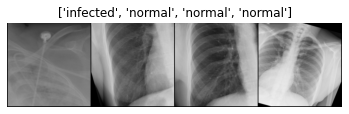

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs[:4], classes[:4])

In [0]:
from tqdm import tqdm
import pickle

In [0]:
def model_training(trainLoader, valdLoader, model, directory, modelName, Epochs=5, momentum=0.9,lr=0.001, acc_loss_dic=None):


    #if you have gpu then you need to convert the network and data to cuda
    #the easiest way is to first check for device and then convert network and data to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)


    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


    model.to(device)
    training_loss = list()
    vald_loss = list()
    training_acc = list()
    vald_acc = list()
    no_epoch_already = 0

    if acc_loss_dic != None:
        training_loss = acc_loss_dic['t_loss']
        vald_loss = acc_loss_dic['v_loss']
        training_acc = acc_loss_dic['t_acc']
        vald_acc = acc_loss_dic['v_acc']
        no_epoch_already = len(training_loss)
        print("Model is trained on",no_epoch_already,"epochs already!")


    val_len = len(valdLoader.dataset)
    train_len = len(trainLoader.dataset)
    

    for epoch in range(no_epoch_already, no_epoch_already+Epochs):  # loop over the dataset multiple times
        
        train_loss = 0.0
        train_acc = 0.0
        pbar = tqdm(enumerate(trainloader))
        model.train()

        for i, data in pbar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update

            _, predictions = torch.max(outputs,1)
            train_loss += (loss.item()*inputs.size(0))
            train_acc += torch.sum(predictions == labels.data)

            pbar.set_description( 'Train Epoch: {} [{}/{} ({:.0f}%)] \tLoss: {:.6f} '.format(
                    epoch, i * len(inputs), len(trainloader.dataset),  100. * i / len(trainloader),
                    loss.item()))
            
        trnLoss_per_ep = train_loss/train_len
        trnAcc_per_ep = train_acc/train_len
        training_loss.append(trnLoss_per_ep)
        training_acc.append(trnAcc_per_ep)
        print("\ntraining loss:  %.6f \t" % trnLoss_per_ep, " training Acc:  %.6f  %%" % (trnAcc_per_ep*100))

        #PERFORMANCE ON EPOCH
        #FOR Validation DATA-SET
        val_acc = 0.0
        val_loss = 0.0
        
        model.eval()

        for i, data in enumerate(valLoader):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)             
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, targets)   
    
            val_loss += (loss.item()*inputs.size(0))
            val_acc += torch.sum(preds == targets.data)

        valLoss_per_ep = val_loss/val_len
        valAcc_per_ep = val_acc/val_len
        vald_loss.append(valLoss_per_ep)
        vald_acc.append(valAcc_per_ep)
        print("Validtion loss:  %.6f \t" % valLoss_per_ep, " Validation Acc:  %.6f  %%" % (100*valAcc_per_ep))

        acc_loss = {"t_acc":training_acc, "t_loss":training_loss, "v_acc":vald_acc, "v_loss": vald_loss}    
        with open(directory+'acc_loss.pkl', 'wb') as obj:
            pickle.dump(acc_loss,obj)        
        torch.save(model.state_dict(), directory+modelName+'.pth')

    print('Finished Training')

    return model, acc_loss


In [18]:
vgg16_FC_only = models.vgg16(pretrained=True)
print(vgg16_FC_only)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [22]:
for param in vgg16_FC_only.features.parameters():
    param.requires_grad = False
new_features = [nn.Linear(25088, 510), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(510, 2) ]
vgg16_FC_only.classifier = nn.Sequential(*new_features)
print(vgg16_FC_only)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
### Only FC layer parameters require_gradient others are freezed
for param in vgg16_FC_only.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


Vgg16 Only fine-tuning FC layer

In [0]:
## setting directory to continue with saved model
directory_vggFC = './gdrive/My Drive/Colab Notebooks/DL/covid_p1/vgg16_Fc/'

In [27]:
##loading old accuracy and loss values
with open(directory_vggFC+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

#loading previosuly saved model
vgg16_FC_only.load_state_dict(torch.load(directory_vggFC+'vgg16_FC_Only.pth'))


<All keys matched successfully>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_curves(list_epochs, list_train_val, list_valdation_val, modelName, curveName ):
    plt.plot(list_epochs, list_train_val)
    plt.plot(list_epochs, list_valdation_val)
    plt.title(modelName+ " " + curveName + " "+ " wrt epochs")
    plt.xlabel("epochs")
    plt.ylabel(curveName)
    plt.legend(["training","validation"], loc='best')
    plt.show()


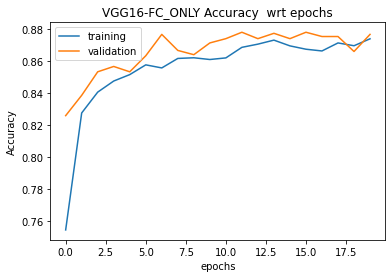

In [30]:
no_epoch_trained = len(acc_loss_dict['t_acc'])

plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "VGG16-FC_ONLY", "Accuracy" )

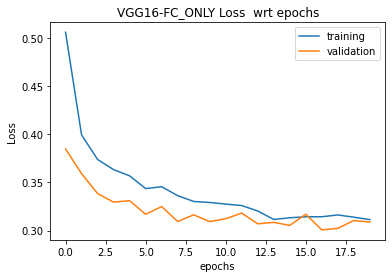

In [32]:
plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "VGG16-FC_ONLY", "Loss" )

In [35]:
## training for 5 more epochs and will see the trend 
vgg16_FC_only, acc_loss_dict = model_training(trainloader, valLoader, vgg16_FC_only, directory_vggFC, "vgg16_FcOnly", 5 ,0.9,0.0001, acc_loss_dic=acc_loss_dict) 

0it [00:00, ?it/s]

cuda:0
Model is trained on 20 epochs already!


Train Epoch: 20 [11968/12000 (100%)] 	Loss: 0.443914 : : 375it [04:36,  1.35it/s]



training loss:  0.304210 	  training Acc:  87.549995  %
Validtion loss:  0.298617 	  Validation Acc:  87.333336  %


Train Epoch: 21 [11968/12000 (100%)] 	Loss: 0.267574 : : 375it [04:24,  1.42it/s]



training loss:  0.307898 	  training Acc:  87.358330  %
Validtion loss:  0.297915 	  Validation Acc:  87.666664  %


Train Epoch: 22 [11968/12000 (100%)] 	Loss: 0.375339 : : 375it [04:14,  1.47it/s]



training loss:  0.307041 	  training Acc:  87.391670  %
Validtion loss:  0.297364 	  Validation Acc:  87.533333  %


Train Epoch: 23 [11968/12000 (100%)] 	Loss: 0.424714 : : 375it [04:13,  1.48it/s]



training loss:  0.305228 	  training Acc:  87.666664  %
Validtion loss:  0.298330 	  Validation Acc:  87.799995  %


Train Epoch: 24 [11968/12000 (100%)] 	Loss: 0.274214 : : 375it [04:11,  1.49it/s]



training loss:  0.304400 	  training Acc:  87.275002  %
Validtion loss:  0.295677 	  Validation Acc:  87.666664  %
Finished Training


In [0]:
def test_some_image(model, testloader=testloader , quantity=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    model.eval()
    images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
    images = images[:quantity]
    labels = labels[:quantity]
    outputs = model(images)                               #--> forward pass
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                                for j in range(len(images))))
    print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                                for j in range(len(images))))

In [0]:
from sklearn.metrics import confusion_matrix,f1_score

def calculate_cm_fscore(loader, loaderName, model, modelName):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    targets = list()
    all_predics = list()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            targets += list( labels.view(-1).cpu().numpy())
            all_predics += (list(predicted.view(-1).cpu().numpy()))

    print(loaderName+' Accuracy of the '+modelName+' fine-tuning entire net on ',len(loader.dataset.imgs),' '+loaderName+' images: %.4f %%' % (100 * correct / total))
    print("classes: ",test_data.classes)
    cm=confusion_matrix(y_true=targets,y_pred=all_predics ) 
    print(cm)
    print("Accuracies by class: ", cm.diagonal()/cm.sum(1))
    print("f1 score for "+modelName+" is %.2f " %(100*f1_score(targets, all_predics, average='binary')) )
    return cm

In [49]:
# vgg16_FC_only, acc_loss_dict

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
test_some_image(vgg16_FC_only,testloader,10)

Predicted:  infected normal infected normal normal infected normal normal normal infected
Ground Truth:  infected normal infected normal normal infected normal normal normal infected


Checking model Accuracy on testing data

In [95]:
cm_ = calculate_cm_fscore(testloader,"Test", vgg16_FC_only,"VGG-16")


Test Accuracy of the VGG-16 fine-tuning entire net on  1500  Test images: 94.0667 %
classes:  ['infected', 'normal']
[[552  63]
 [ 26 859]]
Accuracies by class:  [0.89756098 0.97062147]
f1 score for VGG-16 is 95.07 


Text(0.5, 1.0, 'Confusion Matrix VGG-16 Fine-Tune FC layer on test-data')

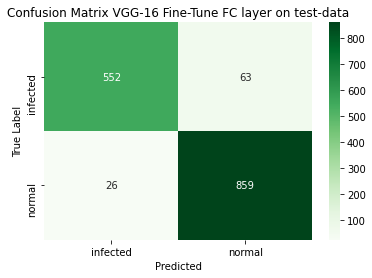

In [96]:
ax = plt.subplot()
sns.heatmap(cm_, annot=True, ax=ax, fmt='g', cmap='Greens')
ax.set_xlabel('Predicted'); ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(test_data.classes)
ax.yaxis.set_ticklabels(test_data.classes)
ax.set_title("Confusion Matrix VGG-16 Fine-Tune FC layer on test-data")

Checking model accuracy and loss curves after more training

After 5 more epochs of training...


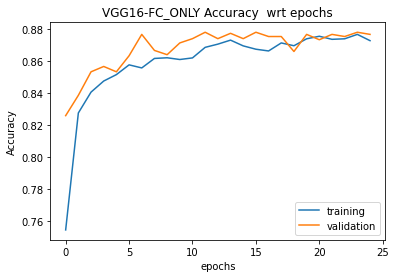

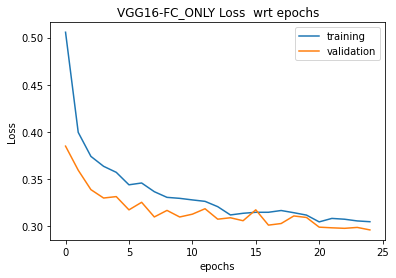

In [88]:
with open(directory_vggFC+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

print("After 5 more epochs of training...")
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "VGG16-FC_ONLY", "Accuracy" )
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "VGG16-FC_ONLY", "Loss" )


ResNet-18 Only fine-tuning FC layer

In [56]:
resnet18_FC_only = models.resnet18(pretrained=True)
print(resnet18_FC_only)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [58]:
#Freezing all
for param in resnet18_FC_only.parameters():
    param.requires_grad = False

#un-freezing last FC layer
new_fc_resnet = [nn.Linear(512, 510), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(510, 2) ]
resnet18_FC_only.fc = nn.Sequential(*new_fc_resnet)

for param in resnet18_FC_only.fc.parameters():
    param.requires_grad = True
   

print(resnet18_FC_only)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
for param in resnet18_FC_only.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [0]:
## setting directory to continue with saved model
directory_resnetFC = './gdrive/My Drive/Colab Notebooks/DL/covid_p1/resnet18_Fc/'


In [65]:
with open(directory_resnetFC+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

#loading previosuly saved model
resnet18_FC_only.load_state_dict(torch.load(directory_resnetFC+'resnet_FC_Only.pth'))


<All keys matched successfully>

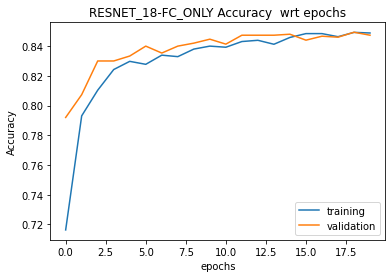

In [66]:
no_epoch_trained = len(acc_loss_dict['t_acc'])

plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "RESNET_18-FC_ONLY", "Accuracy" )


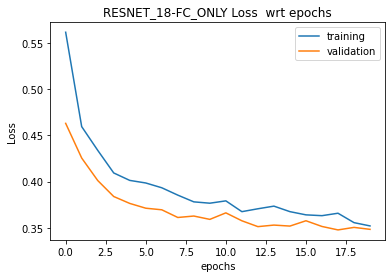

In [67]:
plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "RESNET_18-FC_ONLY", "Loss" )

In [70]:
## training for 5 more epochs and will see the trend 
resnet18_FC_only, acc_loss_dict = model_training(trainloader, valLoader, resnet18_FC_only, directory_resnetFC, "resnet18_FcOnly", 5 ,0.9,0.0001, acc_loss_dic=acc_loss_dict) 



0it [00:00, ?it/s]

cuda:0
Model is trained on 20 epochs already!



Train Epoch: 20 [0/12000 (0%)] 	Loss: 0.300260 : : 0it [00:00, ?it/s]
Train Epoch: 20 [0/12000 (0%)] 	Loss: 0.300260 : : 1it [00:00,  1.60it/s]
Train Epoch: 20 [32/12000 (0%)] 	Loss: 0.361130 : : 1it [00:01,  1.60it/s]
Train Epoch: 20 [32/12000 (0%)] 	Loss: 0.361130 : : 2it [00:01,  1.59it/s]
Train Epoch: 20 [64/12000 (1%)] 	Loss: 0.377593 : : 2it [00:01,  1.59it/s]
Train Epoch: 20 [64/12000 (1%)] 	Loss: 0.377593 : : 3it [00:01,  1.62it/s]
Train Epoch: 20 [96/12000 (1%)] 	Loss: 0.513608 : : 3it [00:02,  1.62it/s]
Train Epoch: 20 [96/12000 (1%)] 	Loss: 0.513608 : : 4it [00:02,  1.62it/s]
Train Epoch: 20 [128/12000 (1%)] 	Loss: 0.355015 : : 4it [00:03,  1.62it/s]
Train Epoch: 20 [128/12000 (1%)] 	Loss: 0.355015 : : 5it [00:03,  1.60it/s]
Train Epoch: 20 [160/12000 (1%)] 	Loss: 0.204349 : : 5it [00:03,  1.60it/s]
Train Epoch: 20 [160/12000 (1%)] 	Loss: 0.204349 : : 6it [00:03,  1.59it/s]
Train Epoch: 20 [192/12000 (2%)] 	Loss: 0.417148 : : 6it [00:04,  1.59it/s]
Train Epoch: 20 [192/1200


training loss:  0.364238 	  training Acc:  84.791664  %



0it [00:00, ?it/s]

Validtion loss:  0.345152 	  Validation Acc:  85.133331  %



Train Epoch: 21 [0/12000 (0%)] 	Loss: 0.252908 : : 0it [00:00, ?it/s]
Train Epoch: 21 [0/12000 (0%)] 	Loss: 0.252908 : : 1it [00:00,  1.56it/s]
Train Epoch: 21 [32/12000 (0%)] 	Loss: 0.435682 : : 1it [00:01,  1.56it/s]
Train Epoch: 21 [32/12000 (0%)] 	Loss: 0.435682 : : 2it [00:01,  1.56it/s]
Train Epoch: 21 [64/12000 (1%)] 	Loss: 0.397172 : : 2it [00:01,  1.56it/s]
Train Epoch: 21 [64/12000 (1%)] 	Loss: 0.397172 : : 3it [00:01,  1.59it/s]
Train Epoch: 21 [96/12000 (1%)] 	Loss: 0.362469 : : 3it [00:02,  1.59it/s]
Train Epoch: 21 [96/12000 (1%)] 	Loss: 0.362469 : : 4it [00:02,  1.46it/s]
Train Epoch: 21 [128/12000 (1%)] 	Loss: 0.408039 : : 4it [00:03,  1.46it/s]
Train Epoch: 21 [128/12000 (1%)] 	Loss: 0.408039 : : 5it [00:03,  1.51it/s]
Train Epoch: 21 [160/12000 (1%)] 	Loss: 0.497455 : : 5it [00:03,  1.51it/s]
Train Epoch: 21 [160/12000 (1%)] 	Loss: 0.497455 : : 6it [00:03,  1.55it/s]
Train Epoch: 21 [192/12000 (2%)] 	Loss: 0.282284 : : 6it [00:04,  1.55it/s]
Train Epoch: 21 [192/1200


training loss:  0.367841 	  training Acc:  84.308334  %



0it [00:00, ?it/s]

Validtion loss:  0.347903 	  Validation Acc:  84.733330  %



Train Epoch: 22 [0/12000 (0%)] 	Loss: 0.455047 : : 0it [00:00, ?it/s]
Train Epoch: 22 [0/12000 (0%)] 	Loss: 0.455047 : : 1it [00:00,  1.46it/s]
Train Epoch: 22 [32/12000 (0%)] 	Loss: 0.356149 : : 1it [00:01,  1.46it/s]
Train Epoch: 22 [32/12000 (0%)] 	Loss: 0.356149 : : 2it [00:01,  1.51it/s]
Train Epoch: 22 [64/12000 (1%)] 	Loss: 0.394923 : : 2it [00:01,  1.51it/s]
Train Epoch: 22 [64/12000 (1%)] 	Loss: 0.394923 : : 3it [00:01,  1.55it/s]
Train Epoch: 22 [96/12000 (1%)] 	Loss: 0.388465 : : 3it [00:02,  1.55it/s]
Train Epoch: 22 [96/12000 (1%)] 	Loss: 0.388465 : : 4it [00:02,  1.55it/s]
Train Epoch: 22 [128/12000 (1%)] 	Loss: 0.304480 : : 4it [00:03,  1.55it/s]
Train Epoch: 22 [128/12000 (1%)] 	Loss: 0.304480 : : 5it [00:03,  1.58it/s]
Train Epoch: 22 [160/12000 (1%)] 	Loss: 0.517451 : : 5it [00:03,  1.58it/s]
Train Epoch: 22 [160/12000 (1%)] 	Loss: 0.517451 : : 6it [00:03,  1.58it/s]
Train Epoch: 22 [192/12000 (2%)] 	Loss: 0.531083 : : 6it [00:04,  1.58it/s]
Train Epoch: 22 [192/1200


training loss:  0.364284 	  training Acc:  84.349998  %



0it [00:00, ?it/s]

Validtion loss:  0.345352 	  Validation Acc:  85.333336  %



Train Epoch: 23 [0/12000 (0%)] 	Loss: 0.309642 : : 0it [00:00, ?it/s]
Train Epoch: 23 [0/12000 (0%)] 	Loss: 0.309642 : : 1it [00:00,  1.46it/s]
Train Epoch: 23 [32/12000 (0%)] 	Loss: 0.267162 : : 1it [00:01,  1.46it/s]
Train Epoch: 23 [32/12000 (0%)] 	Loss: 0.267162 : : 2it [00:01,  1.50it/s]
Train Epoch: 23 [64/12000 (1%)] 	Loss: 0.488476 : : 2it [00:01,  1.50it/s]
Train Epoch: 23 [64/12000 (1%)] 	Loss: 0.488476 : : 3it [00:01,  1.55it/s]
Train Epoch: 23 [96/12000 (1%)] 	Loss: 0.303286 : : 3it [00:02,  1.55it/s]
Train Epoch: 23 [96/12000 (1%)] 	Loss: 0.303286 : : 4it [00:02,  1.54it/s]
Train Epoch: 23 [128/12000 (1%)] 	Loss: 0.298342 : : 4it [00:03,  1.54it/s]
Train Epoch: 23 [128/12000 (1%)] 	Loss: 0.298342 : : 5it [00:03,  1.56it/s]
Train Epoch: 23 [160/12000 (1%)] 	Loss: 0.555792 : : 5it [00:03,  1.56it/s]
Train Epoch: 23 [160/12000 (1%)] 	Loss: 0.555792 : : 6it [00:03,  1.59it/s]
Train Epoch: 23 [192/12000 (2%)] 	Loss: 0.419558 : : 6it [00:04,  1.59it/s]
Train Epoch: 23 [192/1200


training loss:  0.365233 	  training Acc:  84.708336  %



0it [00:00, ?it/s]

Validtion loss:  0.350161 	  Validation Acc:  84.599998  %



Train Epoch: 24 [0/12000 (0%)] 	Loss: 0.332775 : : 0it [00:00, ?it/s]
Train Epoch: 24 [0/12000 (0%)] 	Loss: 0.332775 : : 1it [00:00,  1.63it/s]
Train Epoch: 24 [32/12000 (0%)] 	Loss: 0.353659 : : 1it [00:01,  1.63it/s]
Train Epoch: 24 [32/12000 (0%)] 	Loss: 0.353659 : : 2it [00:01,  1.63it/s]
Train Epoch: 24 [64/12000 (1%)] 	Loss: 0.206299 : : 2it [00:01,  1.63it/s]
Train Epoch: 24 [64/12000 (1%)] 	Loss: 0.206299 : : 3it [00:01,  1.64it/s]
Train Epoch: 24 [96/12000 (1%)] 	Loss: 0.300738 : : 3it [00:02,  1.64it/s]
Train Epoch: 24 [96/12000 (1%)] 	Loss: 0.300738 : : 4it [00:02,  1.65it/s]
Train Epoch: 24 [128/12000 (1%)] 	Loss: 0.289111 : : 4it [00:03,  1.65it/s]
Train Epoch: 24 [128/12000 (1%)] 	Loss: 0.289111 : : 5it [00:03,  1.65it/s]
Train Epoch: 24 [160/12000 (1%)] 	Loss: 0.320961 : : 5it [00:03,  1.65it/s]
Train Epoch: 24 [160/12000 (1%)] 	Loss: 0.320961 : : 6it [00:03,  1.49it/s]
Train Epoch: 24 [192/12000 (2%)] 	Loss: 0.393132 : : 6it [00:04,  1.49it/s]
Train Epoch: 24 [192/1200


training loss:  0.358396 	  training Acc:  84.824997  %
Validtion loss:  0.344418 	  Validation Acc:  85.399994  %
Finished Training


In [71]:
test_some_image(resnet18_FC_only,testloader,10)


Predicted:  normal normal infected normal normal normal normal infected normal normal
Ground Truth:  normal normal infected normal normal normal infected infected normal infected


In [97]:
cm_ = calculate_cm_fscore(testloader,"Test", resnet18_FC_only,"RESNET-18")


Test Accuracy of the RESNET-18 fine-tuning entire net on  1500  Test images: 92.0000 %
classes:  ['infected', 'normal']
[[536  79]
 [ 41 844]]
Accuracies by class:  [0.87154472 0.95367232]
f1 score for RESNET-18 is 93.36 


Text(0.5, 1.0, 'Confusion Matrix RESNET-16 Fine-Tuned FC-layer on test-data')

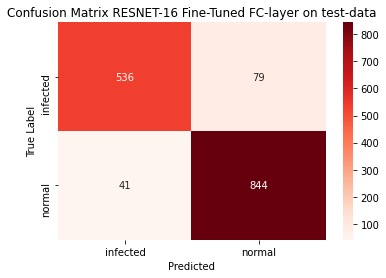

In [98]:
ax = plt.subplot()
sns.heatmap(cm_, annot=True, ax=ax, fmt='g', cmap='Reds')
ax.set_xlabel('Predicted'); ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(test_data.classes)
ax.yaxis.set_ticklabels(test_data.classes)
ax.set_title("Confusion Matrix RESNET-16 Fine-Tuned FC-layer on test-data")


After 5 more epochs of training...


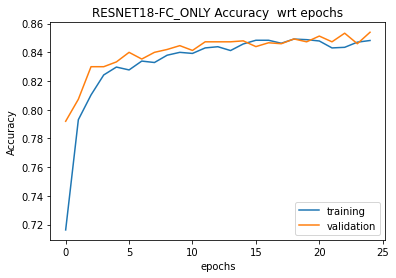

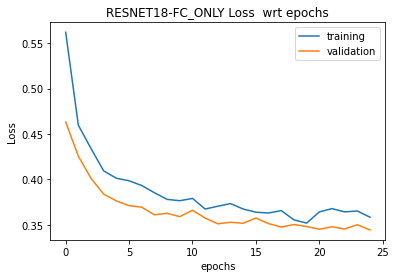

In [92]:
with open(directory_resnetFC+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

print("After 5 more epochs of training...")
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "RESNET18-FC_ONLY", "Accuracy" )
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "RESNET18-FC_ONLY", "Loss" )



VGG-16 fine-tuned entire network with covid dataset


In [79]:
## here instead of just fine tuning FC layer, WHOLE network will be fine-tuned
vgg16_Entire = models.vgg16(pretrained=True)
print(vgg16_Entire)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [80]:

new_features = [nn.Linear(25088, 510), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(510, 2) ]
vgg16_Entire.classifier = nn.Sequential(*new_features)

for param in vgg16_Entire.parameters():
    param.requires_grad = True
## cheching for after unfreezing all layers
for param in vgg16_Entire.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [81]:
## setting directory to continue with saved model
directory_vggEntire = './gdrive/My Drive/Colab Notebooks/DL/covid_p1/vgg16_Entire/'

with open(directory_vggEntire+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

#loading previosuly saved model
vgg16_Entire.load_state_dict(torch.load(directory_vggEntire+'vgg16_entire.pth'))



<All keys matched successfully>

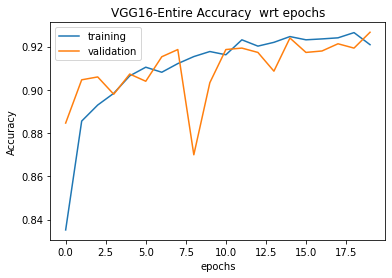

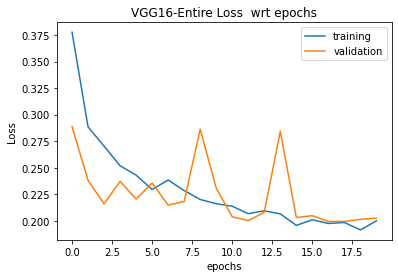

In [82]:
no_epoch_trained = len(acc_loss_dict['t_acc'])
plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "VGG16-Entire", "Accuracy" )
plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "VGG16-Entire", "Loss" )


In [84]:
## training for 5 more epochs and will see the trend 
vgg16_Entire, acc_loss_dict = model_training(trainloader, valLoader, vgg16_Entire, directory_vggEntire, "Vgg16_Entire", 5 ,0.9,0.0001, acc_loss_dic=acc_loss_dict) 




0it [00:00, ?it/s]

cuda:0
Model is trained on 20 epochs already!




Train Epoch: 20 [0/12000 (0%)] 	Loss: 0.263825 : : 0it [00:00, ?it/s]

Train Epoch: 20 [0/12000 (0%)] 	Loss: 0.263825 : : 1it [00:00,  1.11it/s]

Train Epoch: 20 [32/12000 (0%)] 	Loss: 0.306589 : : 1it [00:01,  1.11it/s]

Train Epoch: 20 [32/12000 (0%)] 	Loss: 0.306589 : : 2it [00:01,  1.12it/s]

Train Epoch: 20 [64/12000 (1%)] 	Loss: 0.226355 : : 2it [00:03,  1.12it/s]

Train Epoch: 20 [64/12000 (1%)] 	Loss: 0.226355 : : 3it [00:03,  1.00s/it]

Train Epoch: 20 [96/12000 (1%)] 	Loss: 0.072025 : : 3it [00:03,  1.00s/it]

Train Epoch: 20 [96/12000 (1%)] 	Loss: 0.072025 : : 4it [00:03,  1.04it/s]

Train Epoch: 20 [128/12000 (1%)] 	Loss: 0.135996 : : 4it [00:04,  1.04it/s]

Train Epoch: 20 [128/12000 (1%)] 	Loss: 0.135996 : : 5it [00:04,  1.07it/s]

Train Epoch: 20 [160/12000 (1%)] 	Loss: 0.270579 : : 5it [00:05,  1.07it/s]

Train Epoch: 20 [160/12000 (1%)] 	Loss: 0.270579 : : 6it [00:05,  1.09it/s]

Train Epoch: 20 [192/12000 (2%)] 	Loss: 0.096177 : : 6it [00:06,  1.09it/s]

Train Epoch


training loss:  0.173830 	  training Acc:  93.349998  %
Validtion loss:  0.185641 	  Validation Acc:  93.066666  %




0it [00:00, ?it/s]

Train Epoch: 21 [0/12000 (0%)] 	Loss: 0.145809 : : 0it [00:00, ?it/s]

Train Epoch: 21 [0/12000 (0%)] 	Loss: 0.145809 : : 1it [00:00,  1.23it/s]

Train Epoch: 21 [32/12000 (0%)] 	Loss: 0.109605 : : 1it [00:01,  1.23it/s]

Train Epoch: 21 [32/12000 (0%)] 	Loss: 0.109605 : : 2it [00:01,  1.21it/s]

Train Epoch: 21 [64/12000 (1%)] 	Loss: 0.303071 : : 2it [00:02,  1.21it/s]

Train Epoch: 21 [64/12000 (1%)] 	Loss: 0.303071 : : 3it [00:02,  1.22it/s]

Train Epoch: 21 [96/12000 (1%)] 	Loss: 0.522822 : : 3it [00:03,  1.22it/s]

Train Epoch: 21 [96/12000 (1%)] 	Loss: 0.522822 : : 4it [00:03,  1.22it/s]

Train Epoch: 21 [128/12000 (1%)] 	Loss: 0.112814 : : 4it [00:04,  1.22it/s]

Train Epoch: 21 [128/12000 (1%)] 	Loss: 0.112814 : : 5it [00:04,  1.21it/s]

Train Epoch: 21 [160/12000 (1%)] 	Loss: 0.433676 : : 5it [00:04,  1.21it/s]

Train Epoch: 21 [160/12000 (1%)] 	Loss: 0.433676 : : 6it [00:04,  1.22it/s]

Train Epoch: 21 [192/12000 (2%)] 	Loss: 0.171378 : : 6it [00:05,  1.


training loss:  0.170177 	  training Acc:  93.516663  %
Validtion loss:  0.185926 	  Validation Acc:  92.933334  %




0it [00:00, ?it/s]

Train Epoch: 22 [0/12000 (0%)] 	Loss: 0.172270 : : 0it [00:00, ?it/s]

Train Epoch: 22 [0/12000 (0%)] 	Loss: 0.172270 : : 1it [00:00,  1.20it/s]

Train Epoch: 22 [32/12000 (0%)] 	Loss: 0.252004 : : 1it [00:01,  1.20it/s]

Train Epoch: 22 [32/12000 (0%)] 	Loss: 0.252004 : : 2it [00:01,  1.20it/s]

Train Epoch: 22 [64/12000 (1%)] 	Loss: 0.140859 : : 2it [00:02,  1.20it/s]

Train Epoch: 22 [64/12000 (1%)] 	Loss: 0.140859 : : 3it [00:02,  1.21it/s]

Train Epoch: 22 [96/12000 (1%)] 	Loss: 0.283821 : : 3it [00:03,  1.21it/s]

Train Epoch: 22 [96/12000 (1%)] 	Loss: 0.283821 : : 4it [00:03,  1.21it/s]

Train Epoch: 22 [128/12000 (1%)] 	Loss: 0.128986 : : 4it [00:04,  1.21it/s]

Train Epoch: 22 [128/12000 (1%)] 	Loss: 0.128986 : : 5it [00:04,  1.20it/s]

Train Epoch: 22 [160/12000 (1%)] 	Loss: 0.210023 : : 5it [00:05,  1.20it/s]

Train Epoch: 22 [160/12000 (1%)] 	Loss: 0.210023 : : 6it [00:05,  1.11it/s]

Train Epoch: 22 [192/12000 (2%)] 	Loss: 0.026398 : : 6it [00:06,  1.


training loss:  0.173004 	  training Acc:  93.441666  %
Validtion loss:  0.182742 	  Validation Acc:  93.066666  %




0it [00:00, ?it/s]

Train Epoch: 23 [0/12000 (0%)] 	Loss: 0.234386 : : 0it [00:00, ?it/s]

Train Epoch: 23 [0/12000 (0%)] 	Loss: 0.234386 : : 1it [00:00,  1.14it/s]

Train Epoch: 23 [32/12000 (0%)] 	Loss: 0.171758 : : 1it [00:01,  1.14it/s]

Train Epoch: 23 [32/12000 (0%)] 	Loss: 0.171758 : : 2it [00:01,  1.17it/s]

Train Epoch: 23 [64/12000 (1%)] 	Loss: 0.189144 : : 2it [00:02,  1.17it/s]

Train Epoch: 23 [64/12000 (1%)] 	Loss: 0.189144 : : 3it [00:02,  1.19it/s]

Train Epoch: 23 [96/12000 (1%)] 	Loss: 0.253773 : : 3it [00:03,  1.19it/s]

Train Epoch: 23 [96/12000 (1%)] 	Loss: 0.253773 : : 4it [00:03,  1.17it/s]

Train Epoch: 23 [128/12000 (1%)] 	Loss: 0.149139 : : 4it [00:04,  1.17it/s]

Train Epoch: 23 [128/12000 (1%)] 	Loss: 0.149139 : : 5it [00:04,  1.17it/s]

Train Epoch: 23 [160/12000 (1%)] 	Loss: 0.234196 : : 5it [00:05,  1.17it/s]

Train Epoch: 23 [160/12000 (1%)] 	Loss: 0.234196 : : 6it [00:05,  1.17it/s]

Train Epoch: 23 [192/12000 (2%)] 	Loss: 0.110346 : : 6it [00:05,  1.


training loss:  0.165591 	  training Acc:  93.525002  %
Validtion loss:  0.189325 	  Validation Acc:  92.733330  %




0it [00:00, ?it/s]

Train Epoch: 24 [0/12000 (0%)] 	Loss: 0.112062 : : 0it [00:00, ?it/s]

Train Epoch: 24 [0/12000 (0%)] 	Loss: 0.112062 : : 1it [00:00,  1.16it/s]

Train Epoch: 24 [32/12000 (0%)] 	Loss: 0.298003 : : 1it [00:01,  1.16it/s]

Train Epoch: 24 [32/12000 (0%)] 	Loss: 0.298003 : : 2it [00:01,  1.18it/s]

Train Epoch: 24 [64/12000 (1%)] 	Loss: 0.161597 : : 2it [00:02,  1.18it/s]

Train Epoch: 24 [64/12000 (1%)] 	Loss: 0.161597 : : 3it [00:02,  1.19it/s]

Train Epoch: 24 [96/12000 (1%)] 	Loss: 0.197619 : : 3it [00:03,  1.19it/s]

Train Epoch: 24 [96/12000 (1%)] 	Loss: 0.197619 : : 4it [00:03,  1.20it/s]

Train Epoch: 24 [128/12000 (1%)] 	Loss: 0.186924 : : 4it [00:04,  1.20it/s]

Train Epoch: 24 [128/12000 (1%)] 	Loss: 0.186924 : : 5it [00:04,  1.21it/s]

Train Epoch: 24 [160/12000 (1%)] 	Loss: 0.120686 : : 5it [00:05,  1.21it/s]

Train Epoch: 24 [160/12000 (1%)] 	Loss: 0.120686 : : 6it [00:05,  1.11it/s]

Train Epoch: 24 [192/12000 (2%)] 	Loss: 0.080352 : : 6it [00:06,  1.


training loss:  0.167067 	  training Acc:  93.591667  %
Validtion loss:  0.187067 	  Validation Acc:  92.799995  %
Finished Training


In [85]:
test_some_image(vgg16_Entire,testloader,10)

Predicted:  infected infected normal infected infected normal normal infected infected infected
Ground Truth:  infected infected normal infected infected normal normal infected infected infected


Test Accuracy of the VGG-16 fine-tuning entire net on  1500  Test images: 97.7333 %
classes:  ['infected', 'normal']
[[592  23]
 [ 11 874]]
Accuracies by class:  [0.96260163 0.98757062]
f1 score for VGG-16 is 98.09 


Text(0.5, 1.0, 'Confusion Matrix of test-data for net-> Vgg-16 Fine-Tune Entirely ')

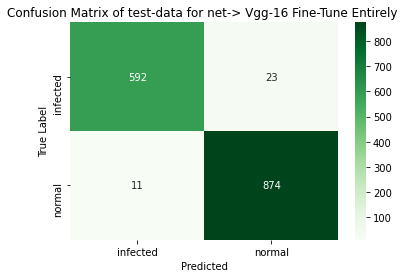

In [99]:
cm_ = calculate_cm_fscore(testloader,"Test", vgg16_Entire,"VGG-16")

ax = plt.subplot()
sns.heatmap(cm_, annot=True, ax=ax, fmt='g', cmap='Greens')
ax.set_xlabel('Predicted'); ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(test_data.classes)
ax.yaxis.set_ticklabels(test_data.classes)
ax.set_title("Confusion Matrix of test-data for net-> Vgg-16 Fine-Tune Entirely ")

After 5 more epochs of training...


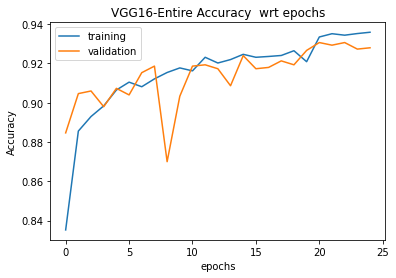

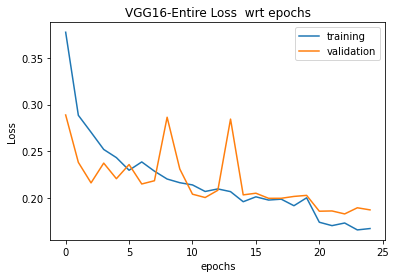

In [90]:
with open(directory_vggEntire+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

print("After 5 more epochs of training...")
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "VGG16-Entire", "Accuracy" )
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "VGG16-Entire", "Loss" )

RES-NET 18 fine-tuned entire network with covid dataset


In [100]:
resnet18_Entire = models.resnet18(pretrained=True)
print(resnet18_Entire)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [107]:

new_features = [nn.Linear(512, 510), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(510, 2) ]
resnet18_Entire.fc = nn.Sequential(*new_features)

for param in resnet18_Entire.parameters():
    param.requires_grad = True

for param in resnet18_Entire.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [108]:
## setting directory to continue with saved model
directory_resnetEntire = './gdrive/My Drive/Colab Notebooks/DL/covid_p1/resnet18_Entire/'

with open(directory_resnetEntire+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

#loading previosuly saved model
resnet18_Entire.load_state_dict(torch.load(directory_resnetEntire+'resnet18_entire.pth'))


<All keys matched successfully>

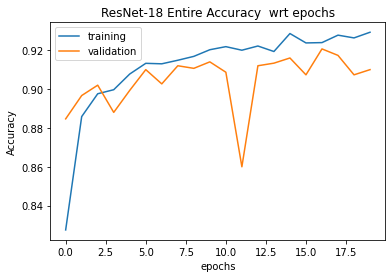

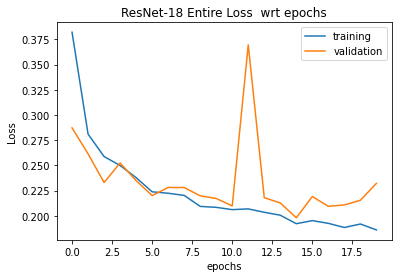

In [109]:
no_epoch_trained = len(acc_loss_dict['t_acc'])
plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "ResNet-18 Entire", "Accuracy" )
plot_curves(list(range(no_epoch_trained)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "ResNet-18 Entire", "Loss" )


In [110]:
## training for 5 more epochs and will see the trend 
resnet18_Entire, acc_loss_dict = model_training(trainloader, valLoader, resnet18_Entire, directory_resnetEntire, "Resnet18_Entire", 5 ,0.9,0.0001, acc_loss_dic=acc_loss_dict) 




0it [00:00, ?it/s]

cuda:0
Model is trained on 20 epochs already!




Train Epoch: 20 [0/12000 (0%)] 	Loss: 0.096453 : : 0it [00:00, ?it/s]

Train Epoch: 20 [0/12000 (0%)] 	Loss: 0.096453 : : 1it [00:00,  1.43it/s]

Train Epoch: 20 [32/12000 (0%)] 	Loss: 0.148006 : : 1it [00:01,  1.43it/s]

Train Epoch: 20 [32/12000 (0%)] 	Loss: 0.148006 : : 2it [00:01,  1.46it/s]

Train Epoch: 20 [64/12000 (1%)] 	Loss: 0.047192 : : 2it [00:01,  1.46it/s]

Train Epoch: 20 [64/12000 (1%)] 	Loss: 0.047192 : : 3it [00:01,  1.48it/s]

Train Epoch: 20 [96/12000 (1%)] 	Loss: 0.185041 : : 3it [00:02,  1.48it/s]

Train Epoch: 20 [96/12000 (1%)] 	Loss: 0.185041 : : 4it [00:02,  1.49it/s]

Train Epoch: 20 [128/12000 (1%)] 	Loss: 0.122753 : : 4it [00:03,  1.49it/s]

Train Epoch: 20 [128/12000 (1%)] 	Loss: 0.122753 : : 5it [00:03,  1.51it/s]

Train Epoch: 20 [160/12000 (1%)] 	Loss: 0.101456 : : 5it [00:04,  1.51it/s]

Train Epoch: 20 [160/12000 (1%)] 	Loss: 0.101456 : : 6it [00:04,  1.46it/s]

Train Epoch: 20 [192/12000 (2%)] 	Loss: 0.179410 : : 6it [00:04,  1.46it/s]

Train Epoch


training loss:  0.181216 	  training Acc:  93.066666  %




0it [00:00, ?it/s]

Validtion loss:  0.203221 	  Validation Acc:  91.933334  %




Train Epoch: 21 [0/12000 (0%)] 	Loss: 0.170750 : : 0it [00:00, ?it/s]

Train Epoch: 21 [0/12000 (0%)] 	Loss: 0.170750 : : 1it [00:00,  1.62it/s]

Train Epoch: 21 [32/12000 (0%)] 	Loss: 0.139747 : : 1it [00:01,  1.62it/s]

Train Epoch: 21 [32/12000 (0%)] 	Loss: 0.139747 : : 2it [00:01,  1.59it/s]

Train Epoch: 21 [64/12000 (1%)] 	Loss: 0.108355 : : 2it [00:01,  1.59it/s]

Train Epoch: 21 [64/12000 (1%)] 	Loss: 0.108355 : : 3it [00:01,  1.59it/s]

Train Epoch: 21 [96/12000 (1%)] 	Loss: 0.205695 : : 3it [00:02,  1.59it/s]

Train Epoch: 21 [96/12000 (1%)] 	Loss: 0.205695 : : 4it [00:02,  1.60it/s]

Train Epoch: 21 [128/12000 (1%)] 	Loss: 0.214123 : : 4it [00:03,  1.60it/s]

Train Epoch: 21 [128/12000 (1%)] 	Loss: 0.214123 : : 5it [00:03,  1.59it/s]

Train Epoch: 21 [160/12000 (1%)] 	Loss: 0.092946 : : 5it [00:03,  1.59it/s]

Train Epoch: 21 [160/12000 (1%)] 	Loss: 0.092946 : : 6it [00:03,  1.57it/s]

Train Epoch: 21 [192/12000 (2%)] 	Loss: 0.126891 : : 6it [00:04,  1.57it/s]

Train Epoch


training loss:  0.173495 	  training Acc:  93.275002  %




0it [00:00, ?it/s]

Validtion loss:  0.207455 	  Validation Acc:  91.799995  %




Train Epoch: 22 [0/12000 (0%)] 	Loss: 0.207929 : : 0it [00:00, ?it/s]

Train Epoch: 22 [0/12000 (0%)] 	Loss: 0.207929 : : 1it [00:00,  1.57it/s]

Train Epoch: 22 [32/12000 (0%)] 	Loss: 0.167094 : : 1it [00:01,  1.57it/s]

Train Epoch: 22 [32/12000 (0%)] 	Loss: 0.167094 : : 2it [00:01,  1.58it/s]

Train Epoch: 22 [64/12000 (1%)] 	Loss: 0.052628 : : 2it [00:01,  1.58it/s]

Train Epoch: 22 [64/12000 (1%)] 	Loss: 0.052628 : : 3it [00:01,  1.58it/s]

Train Epoch: 22 [96/12000 (1%)] 	Loss: 0.222076 : : 3it [00:02,  1.58it/s]

Train Epoch: 22 [96/12000 (1%)] 	Loss: 0.222076 : : 4it [00:02,  1.58it/s]

Train Epoch: 22 [128/12000 (1%)] 	Loss: 0.265106 : : 4it [00:03,  1.58it/s]

Train Epoch: 22 [128/12000 (1%)] 	Loss: 0.265106 : : 5it [00:03,  1.56it/s]

Train Epoch: 22 [160/12000 (1%)] 	Loss: 0.065377 : : 5it [00:03,  1.56it/s]

Train Epoch: 22 [160/12000 (1%)] 	Loss: 0.065377 : : 6it [00:03,  1.56it/s]

Train Epoch: 22 [192/12000 (2%)] 	Loss: 0.150952 : : 6it [00:04,  1.56it/s]

Train Epoch


training loss:  0.176064 	  training Acc:  93.241669  %




0it [00:00, ?it/s]

Validtion loss:  0.202556 	  Validation Acc:  92.066666  %




Train Epoch: 23 [0/12000 (0%)] 	Loss: 0.269633 : : 0it [00:00, ?it/s]

Train Epoch: 23 [0/12000 (0%)] 	Loss: 0.269633 : : 1it [00:00,  1.56it/s]

Train Epoch: 23 [32/12000 (0%)] 	Loss: 0.286962 : : 1it [00:01,  1.56it/s]

Train Epoch: 23 [32/12000 (0%)] 	Loss: 0.286962 : : 2it [00:01,  1.56it/s]

Train Epoch: 23 [64/12000 (1%)] 	Loss: 0.299062 : : 2it [00:01,  1.56it/s]

Train Epoch: 23 [64/12000 (1%)] 	Loss: 0.299062 : : 3it [00:01,  1.55it/s]

Train Epoch: 23 [96/12000 (1%)] 	Loss: 0.201105 : : 3it [00:02,  1.55it/s]

Train Epoch: 23 [96/12000 (1%)] 	Loss: 0.201105 : : 4it [00:02,  1.56it/s]

Train Epoch: 23 [128/12000 (1%)] 	Loss: 0.209561 : : 4it [00:03,  1.56it/s]

Train Epoch: 23 [128/12000 (1%)] 	Loss: 0.209561 : : 5it [00:03,  1.56it/s]

Train Epoch: 23 [160/12000 (1%)] 	Loss: 0.179821 : : 5it [00:03,  1.56it/s]

Train Epoch: 23 [160/12000 (1%)] 	Loss: 0.179821 : : 6it [00:03,  1.56it/s]

Train Epoch: 23 [192/12000 (2%)] 	Loss: 0.135420 : : 6it [00:04,  1.56it/s]

Train Epoch


training loss:  0.173622 	  training Acc:  93.316666  %




0it [00:00, ?it/s]

Validtion loss:  0.201319 	  Validation Acc:  92.133331  %




Train Epoch: 24 [0/12000 (0%)] 	Loss: 0.362707 : : 0it [00:00, ?it/s]

Train Epoch: 24 [0/12000 (0%)] 	Loss: 0.362707 : : 1it [00:00,  1.56it/s]

Train Epoch: 24 [32/12000 (0%)] 	Loss: 0.085098 : : 1it [00:01,  1.56it/s]

Train Epoch: 24 [32/12000 (0%)] 	Loss: 0.085098 : : 2it [00:01,  1.55it/s]

Train Epoch: 24 [64/12000 (1%)] 	Loss: 0.100638 : : 2it [00:01,  1.55it/s]

Train Epoch: 24 [64/12000 (1%)] 	Loss: 0.100638 : : 3it [00:01,  1.52it/s]

Train Epoch: 24 [96/12000 (1%)] 	Loss: 0.071697 : : 3it [00:02,  1.52it/s]

Train Epoch: 24 [96/12000 (1%)] 	Loss: 0.071697 : : 4it [00:02,  1.53it/s]

Train Epoch: 24 [128/12000 (1%)] 	Loss: 0.149301 : : 4it [00:03,  1.53it/s]

Train Epoch: 24 [128/12000 (1%)] 	Loss: 0.149301 : : 5it [00:03,  1.54it/s]

Train Epoch: 24 [160/12000 (1%)] 	Loss: 0.243792 : : 5it [00:03,  1.54it/s]

Train Epoch: 24 [160/12000 (1%)] 	Loss: 0.243792 : : 6it [00:03,  1.56it/s]

Train Epoch: 24 [192/12000 (2%)] 	Loss: 0.103590 : : 6it [00:04,  1.56it/s]

Train Epoch


training loss:  0.168937 	  training Acc:  93.508331  %
Validtion loss:  0.202181 	  Validation Acc:  91.533333  %
Finished Training


In [111]:
test_some_image(resnet18_Entire,testloader,10)


Predicted:  normal normal normal infected normal normal normal normal normal normal
Ground Truth:  normal normal normal infected normal normal normal normal normal normal


Test Accuracy of the RESNET-18 fine-tuning entire net on  1500  Test images: 97.6667 %
classes:  ['infected', 'normal']
[[590  25]
 [ 10 875]]
Accuracies by class:  [0.95934959 0.98870056]
f1 score for RESNET-18 is 98.04 


Text(0.5, 1.0, 'Confusion Matrix of test-data for net-> ResNet-18 Fine-Tune Entirely ')

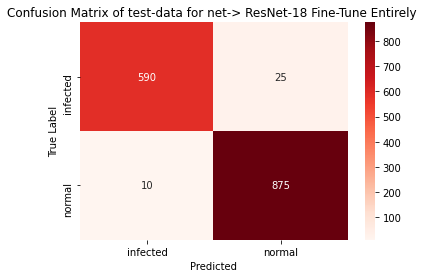

In [112]:
cm_ = calculate_cm_fscore(testloader,"Test", resnet18_Entire,"RESNET-18")
ax = plt.subplot()
sns.heatmap(cm_, annot=True, ax=ax, fmt='g', cmap='Reds')
ax.set_xlabel('Predicted'); ax.set_ylabel('True Label')
ax.xaxis.set_ticklabels(test_data.classes)
ax.yaxis.set_ticklabels(test_data.classes)
ax.set_title("Confusion Matrix of test-data for net-> ResNet-18 Fine-Tune Entirely ")

After 5 more epochs of training...


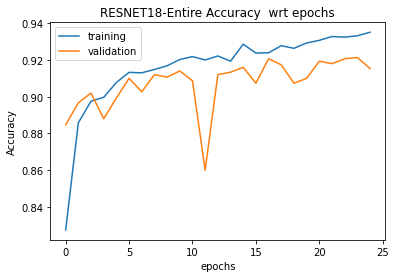

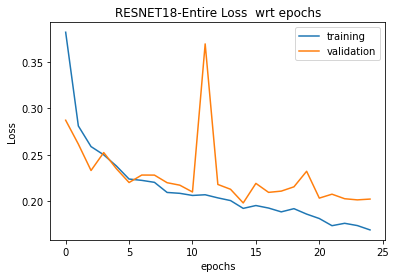

In [113]:
with open(directory_resnetEntire+'acc_loss.pkl', 'rb') as obj:
    acc_loss_dict = pickle.load(obj)

print("After 5 more epochs of training...")
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_acc'], acc_loss_dict['v_acc'], "RESNET18-Entire", "Accuracy" )
plot_curves(list(range(no_epoch_trained+5)),  acc_loss_dict['t_loss'], acc_loss_dict['v_loss'], "RESNET18-Entire", "Loss" )